In [1]:
# adding path objects for the src and data folders
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

# bringing in functions created by my teammates
import data_preprocessing as dp
import model_evaluation as me

# basic data handling packages
import pandas as pd
import numpy as np
import random

# required sklearn packages
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# graphing packages
import seaborn as sns
import matplotlib.pyplot as plt

# keras packages
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier

sns.set(context = 'notebook', style = 'whitegrid')

Using TensorFlow backend.
/opt/anaconda3/envs/tweet_nlp-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tweet_nlp-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tweet_nlp-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/twe

# get data using andrew's clean data functions

The embedding layer won't benifit from lemmatization, so we'll use the no-lem csv here.

In [2]:
csv_path = data_path / 'targeted_combined_no_lem.csv'
cleaned_df = pd.read_csv(csv_path)

In [3]:
cleaned_df.dropna(inplace=True)

In [4]:
cleaned_df.head(5)

,emotion,txt_cleaned
0,0.0,product_target hrs tweeting riseaustin dead ne...
1,2.0,know awesome ipadiphone product_target youll l...
2,2.0,wait product_target also sale sxsw
3,0.0,hope years festival isnt crashy years iphone p...
4,2.0,great stuff fri sxsw marissa mayer product_tar...


extracting the x and y values from the data

In [5]:
y = cleaned_df['emotion']
y

0        0.0
1        2.0
2        2.0
3        0.0
4        2.0
        ... 
22601    0.0
22602    0.0
22603    0.0
22604    0.0
22605    0.0
Name: emotion, Length: 22606, dtype: float64

In [6]:
X = cleaned_df['txt_cleaned']
X

0        product_target hrs tweeting riseaustin dead ne...
1        know awesome ipadiphone product_target youll l...
2                       wait product_target also sale sxsw
3        hope years festival isnt crashy years iphone p...
4        great stuff fri sxsw marissa mayer product_tar...
                               ...                        
22601    literally reason want go rest line kind snooze...
22602                          anyone else completely sold
22603                         recycled fuck product_target
22604                    line already fake like every year
22605                                        fersure thing
Name: txt_cleaned, Length: 22606, dtype: object

checking class balance and null values

In [7]:
y.value_counts()

2.0    8213
0.0    8062
1.0    6331
Name: emotion, dtype: int64

In [8]:
X.isna().value_counts()

False    22606
Name: txt_cleaned, dtype: int64

create a train/test split for final evaluation, then do a train/val split for model development

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, test_size=.1)

# tokenize tweets

the embedding layer needs a tokenized input and it needs to know the shape (the number of unique words in the corpus)

In [10]:
X_train_list = list(X_train)
X_test_list = list(X_test)
X_tr_list = list(X_tr)
X_v_list = list(X_v)

X_train_corpus = []
X_tr_corpus = []
for tweet in X_train_list:
    X_train_corpus.extend(tweet.split(' '))
for tweet in X_tr_list:
    X_tr_corpus.extend(tweet.split(' '))
    
X_train_unique = len(set(X_train_corpus))
X_tr_unique = len(set(X_tr_corpus))

tokenizing and padding the sequences

In [11]:
sequence_length = 100

partial_tokenizer = text.Tokenizer(num_words=X_tr_unique)
full_tokenizer = text.Tokenizer(num_words=X_train_unique)

partial_tokenizer.fit_on_texts(X_tr_list)
full_tokenizer.fit_on_texts(X_train_list)

X_tr_tokenized = partial_tokenizer.texts_to_sequences(X_tr_list)
X_v_tokenized = partial_tokenizer.texts_to_sequences(X_v_list)
X_train_tokenized= full_tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized= full_tokenizer.texts_to_sequences(X_test_list)

X_tr_tokens = sequence.pad_sequences(X_tr_tokenized, maxlen=sequence_length)
X_v_tokens = sequence.pad_sequences(X_v_tokenized, maxlen=sequence_length)
X_train_tokens = sequence.pad_sequences(X_train_tokenized, maxlen=sequence_length)
X_test_tokens = sequence.pad_sequences(X_test_tokenized, maxlen=sequence_length)

# construct CNN with embedding layer

creating a function that returns the keras CNN with embedding

In [13]:
def make_CNN(len_corpus, len_sequence):
    model = Sequential()

    # add embedding layer as input
    embedding_size = 64
    model.add(Embedding(input_dim=len_corpus, output_dim=embedding_size, input_length=sequence_length))
    # feed embeded features into 1 dimensional convolutional layer
    model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
    # dropout to prevent over-fitting
    model.add(Dropout(0.7))
    # aggregate function after convolution
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    # Adding dense layers with dropout for classification on the features generated by embedding and conv layers
    model.add(Dense(units=30, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=10, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=3, activation='softmax'))
    # compile for optimizing accuracy
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
partial_model = make_CNN(X_tr_unique, sequence_length)

# fit model on tokenized data

In [16]:
partial_model.fit(X_tr_tokens, pd.get_dummies(y_tr), validation_data=(X_v_tokens, pd.get_dummies(y_v)), epochs=10, batch_size=32)


Train on 16275 samples, validate on 1809 samples
Epoch 1/10
16275/16275 [==============================] - 13s 820us/step - loss: 1.0320 - accuracy: 0.4551 - val_loss: 0.8856 - val_accuracy: 0.5860
Epoch 2/10
16275/16275 [==============================] - 12s 754us/step - loss: 0.8231 - accuracy: 0.6552 - val_loss: 0.8307 - val_accuracy: 0.6219
Epoch 3/10
16275/16275 [==============================] - 12s 751us/step - loss: 0.6215 - accuracy: 0.7693 - val_loss: 0.8863 - val_accuracy: 0.6280
Epoch 4/10
16275/16275 [==============================] - 13s 777us/step - loss: 0.4829 - accuracy: 0.8308 - val_loss: 1.0670 - val_accuracy: 0.5937
Epoch 5/10
16275/16275 [==============================] - 13s 777us/step - loss: 0.3955 - accuracy: 0.8703 - val_loss: 1.1293 - val_accuracy: 0.6075
Epoch 6/10
16275/16275 [==============================] - 13s 779us/step - loss: 0.3443 - accuracy: 0.8903 - val_loss: 1.2341 - val_accuracy: 0.6086
Epoch 7/10
16275/16275 [==============================] 

evaluate performance

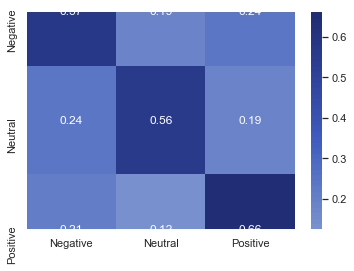

In [17]:
me.plot_confusion_matrix(y_v, np.argmax(partial_model.predict(X_v_tokens), axis=1))

In [18]:
confusion_matrix(y_v, np.argmax(partial_model.predict(X_v_tokens), axis=1))

array([[363, 117, 152],
       [129, 297, 101],
       [139,  81, 430]])

# train model on full train split for validation on 'test'

In [19]:
final_model = make_CNN(X_train_unique, sequence_length)

In [20]:
final_model.fit(X_train_tokens, pd.get_dummies(y_train), validation_data=(X_test_tokens, pd.get_dummies(y_test)), epochs=5, batch_size=128)

Train on 18084 samples, validate on 4522 samples
Epoch 1/5
18084/18084 [==============================] - 7s 367us/step - loss: 1.0667 - accuracy: 0.4089 - val_loss: 0.9781 - val_accuracy: 0.4936
Epoch 2/5
18084/18084 [==============================] - 6s 357us/step - loss: 0.8886 - accuracy: 0.5995 - val_loss: 0.8615 - val_accuracy: 0.6119
Epoch 3/5
18084/18084 [==============================] - 6s 346us/step - loss: 0.7055 - accuracy: 0.7191 - val_loss: 0.8541 - val_accuracy: 0.6117
Epoch 4/5
18084/18084 [==============================] - 6s 342us/step - loss: 0.5542 - accuracy: 0.7974 - val_loss: 0.9100 - val_accuracy: 0.6218
Epoch 5/5
18084/18084 [==============================] - 6s 352us/step - loss: 0.4425 - accuracy: 0.8482 - val_loss: 1.0036 - val_accuracy: 0.6150


evaluate final model performance

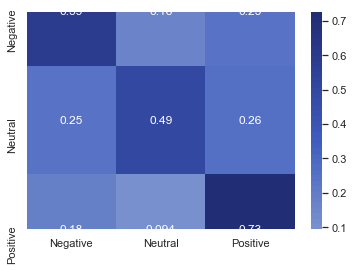

In [22]:
me.plot_confusion_matrix(y_test, np.argmax(final_model.predict(X_test_tokens), axis=1))

In [24]:
confusion_matrix(y_test, np.argmax(final_model.predict(X_test_tokens), axis=1))

array([[ 950,  262,  395],
       [ 308,  607,  315],
       [ 302,  159, 1224]])